# Trigger Word Detection

In [24]:
import numpy as np
from pydub import AudioSegment
from td_utils import graph_spectrogram, match_target_amplitude, load_raw_audio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, TimeDistributed, Conv1D, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam

## 1. Dataset

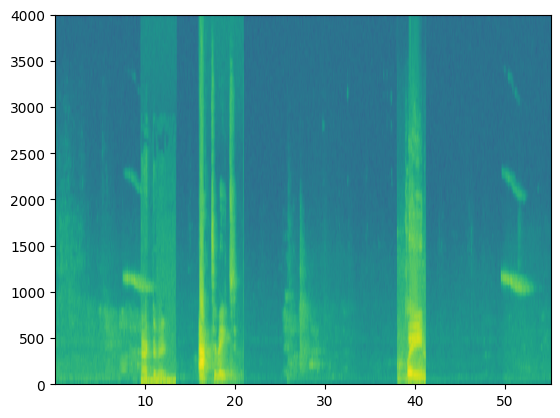

In [11]:
def get_random_time_segment(segment_ms):
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)


def is_overlapping(segment_time, previous_segments):
    segment_start, segment_end = segment_time

    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments: # @KEEP
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break

    return overlap


def insert_audio_clip(background, audio_clip, previous_segments):
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5 # @KEEP 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)

        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
        # print(segment_time)
    else:
        # print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

def insert_ones(y, segment_end_ms):
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1
    
    return y


def create_training_example(background, activates, negatives, Ty):
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates: # @KEEP
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives: # @KEEP
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    # file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y


Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model
activates, negatives, backgrounds = load_raw_audio('./raw_data/')
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

# Save the data for further uses
np.save(f'XY_train/X.npy', X)
np.save(f'XY_train/Y.npy', Y)

In [12]:
X = np.load("XY_train/X.npy") # shape=(32, 5511, 101)
Y = np.load("XY_train/Y.npy") # shape=(32, 1375, 1)
X_dev = np.load("XY_dev/X_dev.npy") # shape=(25, 5511, 101)
Y_dev = np.load("XY_dev/Y_dev.npy") # shape=(25, 1375, 1)
# Có 32 training samples và 25 test samples, Tx=5511 là số time steps trong spectrogram, nx=101 là số frequencies tại một time step, Ty=1375 là số time steps ở output

## 2. Model

<img src="images/model.png" height=800/>

In [21]:
def modelf(input_shape): # Xét một sample có shape (Tx, nx)=(5511, 101)
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer (≈4 lines)
    # Add a Conv1D with 196 units, kernel size of 15 and stride of 4
    X = Conv1D(196, 15, strides=4)(X_input) # shape=(1375, 196)
    # Batch normalization
    X = BatchNormalization()(X)
    # ReLu activation
    X = Activation('relu')(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)                                  

    # Step 2: First GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units = 128, return_sequences=True)(X) # shape=(1375, 128)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)
    # Batch normalization.
    X = BatchNormalization()(X)                          
    
    # Step 3: Second GRU Layer (≈4 lines)
    # GRU (use 128 units and return the sequences)
    X = GRU(units = 128, return_sequences=True)(X) # shape=(1375, 128)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)       
    # Batch normalization
    X = BatchNormalization()(X)
    # dropout (use 0.8)
    X = Dropout(0.8)(X)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    # TimeDistributed  with sigmoid activation 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # Áp dụng layer Dense vào từng time step, shape=(1375, 1)
    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [26]:
model = modelf(input_shape = (Tx, n_freq))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5511, 101)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1375, 196)      │       297,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1375, 196)      │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1375, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 1375, 128)      │       125,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 1375, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1375, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1375, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1375, 1)        │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,329 (2.00 MB)

 Trainable params: 522,425 (1.99 MB)

 Non-trainable params: 904 (3.53 KB)

In [28]:
model.load_weights('models/model.h5')

model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

In [30]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
model.fit(X, Y, batch_size = 16, epochs=1, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 898ms/step - accuracy: 0.8878 - loss: 0.3770


In [31]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - accuracy: 0.9270 - loss: 0.3004
Dev set accuracy =  0.9270400404930115


In [32]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


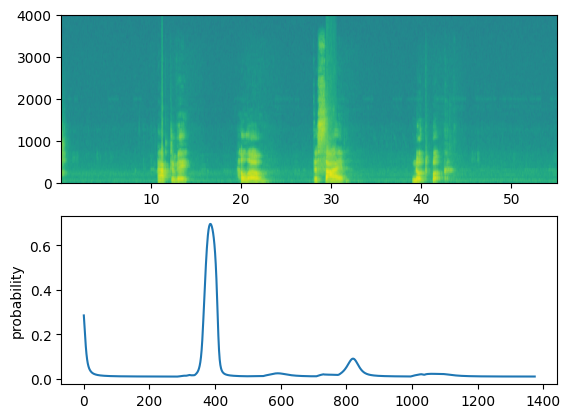

In [33]:
filename = "raw_data/dev/1.wav"
prediction = detect_triggerword(filename)